In [2]:
using Pkg
if !haskey(Pkg.installed(), "Images") || !haskey(Pkg.installed(), "ImageMagick") || !haskey(Pkg.installed(), "FileIO") || !haskey(Pkg.installed(), "Glob")
    println("Installing required packages...")
    Pkg.add.(["Images", "ImageMagick", "FileIO", "Glob"])
end


using Plots
using LinearAlgebra
using GenericLinearAlgebra
using Images
using FileIO
using Glob
using ImageMagick  # pode ser necessário para JPEG


┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744
┌ Warning: Pkg.installed() is deprecated
└ @ Pkg C:\Users\mathe\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Pkg\src\Pkg.jl:744


In [3]:
function complete_orthonormal(U::Matrix{Float64})
    d, r = size(U)
    r ≤ d || error("U deve ter no máximo d colunas")

    r == d && return zeros(Float64, d, 0)   # já completa

    # Projeta vetores aleatórios no complemento de span(U)
    Z = randn(Float64, d, d - r)
    Z .-= U * (U' * Z)                      # remove componente em U

    # QR fino garante ortonormalidade
    C = Matrix(qr(Z).Q)                  # d × (d−r)
    return C
end

complete_orthonormal (generic function with 1 method)

In [4]:
function build_csd_input_matrix(D1::Matrix{Float64}, D2::Matrix{Float64})
    # Dimensões
    m, d = size(D1)  # D1: m x d
    n, _ = size(D2)  # D2: n x d

    # Passo 1: QR de D1^T para obter base de R(D1) em R^d
    Q1 = Matrix(qr(D1').Q)  # Q1 é d x m
    R1 = Matrix(qr(D1').R)  # R1 é m x m

    println("Q1: ", size(Q1))  # Debugging: verificar tamanho de Q1
    println("R1: ", size(R1))  # Debugging: verificar tamanho de R1

    r1 = sum(abs.(diag(R1)) .> eps() * maximum(abs.(diag(R1))))  # Estimar posto
    E1 = Q1[:, 1:r1]  
    E2 = complete_orthonormal(E1)  # Base ortonormal completa para R^d, d x (d - r1)
    E = hcat(E1, E2)  # Base ortonormal completa para R^d, d x d
    
    # Passo 2: QR de D2^T para obter base de R(D2) em R^d
    Q2 = Matrix(qr(D2').Q)  # Q2 é d x n
    R2 = Matrix(qr(D2').R)  # R2 é n x n

    println("Q2: ", size(Q2))  # Debugging: verificar tamanho de Q2
    println("R2: ", size(R2))  # Debugging: verificar tamanho de R2

    c1 = sum(abs.(diag(R2)) .> eps() * maximum(abs.(diag(R2))))  # Estimar posto
    F1 = Q2[:, 1:c1]  
    F2 = complete_orthonormal(F1)  # Base ortonormal completa para R^d, d x (d - c1)
    

    # Passo 3: Calcular Q11 = E1^T F1
    Q11 = E1' * F1  # r1 x c1
    Q12 = E1' * F2  # r1 x (d - c1)
    Q21 = E2' * F1  # (d - r1) x c1
    Q22 = E2' * F2  # (d - r1) x (d - c1)

    # Passo 4: Concatenar Q11, Q12, Q21, Q22
    Qtop = hcat(Q11, Q12)
    Qbot = hcat(Q21, Q22)
    Q = vcat(Qtop, Qbot)
    
    return Q, r1, c1, E, E1, F1, R1, R2
end

build_csd_input_matrix (generic function with 1 method)

In [5]:
function rebuild_datasets_matrices(E, R)
    D_reconstructed = R' * E'  
    # Retornar a matriz reconstruída
    return D_reconstructed
end

rebuild_datasets_matrices (generic function with 1 method)

In [6]:
function verify_Q(Q::Matrix{Float64})
    if Q'*Q ≈ I
        println("A matriz Q é ortonormal")
    else
        println("A matriz Q não é ortonormal")
        
    end
end

verify_Q (generic function with 1 method)

In [7]:
function load_images_as_dataset(folder_path::String, max_images::Int= 100)
    # Lista todos os arquivos JPEG na pasta
    image_paths = Glob.glob("*.jpg", folder_path)
    num_images = min(length(image_paths), max_images)  

    if num_images == 0
        error("Nenhuma imagem encontrada na pasta.")
    end

    # Carrega uma imagem para obter dimensões
    img_sample = load(image_paths[1])
    img_gray = convert(Array{Gray{N0f8}}, img_sample)
    h, w = size(img_gray)

    println("Dimensões da imagem: $h x $w")

    # Inicializa matriz dataset
    dataset = zeros(Float64, num_images, h * w)

    for (i, path) in enumerate(image_paths[1:num_images])
        img = load(path)
        img_gray = convert(Array{Gray{N0f8}}, img)  # Converte para escala de cinza
        dataset[i, :] = vec(img_gray)  # Converte a imagem para vetor e armazena
    end

    return dataset, h, w
end



load_images_as_dataset (generic function with 2 methods)

In [8]:
function reconstruct_image_from_vector(X::Matrix{Float64}, h::Int, w::Int, img_num::Int)
    vec_img = X[img_num, :]
    img_gray = reshape(vec_img, h, w)  # Reshape para a imagem em escala de cinza
    
    return img_gray
end


reconstruct_image_from_vector (generic function with 1 method)

In [9]:
number = 0
folder1 = raw"MNIST\trainingSet\\"*string(number)
X, h, w = load_images_as_dataset(folder1)
size(X) 

Dimensões da imagem: 28 x 28


(100, 784)

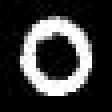

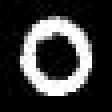

In [10]:
num1 = 1  # Número da imagem que você quer reconstruir
#se o folder contém "train", usa o formato com zeros à esquerda
#se não (se for "test"), usa o formato sem zeros à esquerda
img_path = (folder1 * "\\img_" * string(num1) * ".jpg") 
img9 = load(img_path)
display(img9)
num = 1
img9_reconstruct= reconstruct_image_from_vector(X, h, w, num)
display(colorview(Gray, img9_reconstruct))

In [11]:
function display_image_grid(X::Matrix{Float64}, img_size::Tuple{Int,Int}, indices::Vector{Int}; grid_shape::Tuple{Int,Int}=nothing)
    n_imgs = length(indices)
    h, w = img_size

    # Define grid shape if not provided
    if grid_shape === nothing
        ncols = ceil(Int, sqrt(n_imgs))
        nrows = ceil(Int, n_imgs / ncols)
    else
        nrows, ncols = grid_shape
    end

    # Create empty canvas for each channel
    grid = zeros(Float64, nrows*h, ncols*w)

    n_pixels = h * w

    for (k, idx) in enumerate(indices)
        row = div(k-1, ncols)
        col = mod(k-1, ncols)
        img_gray =reconstruct_image_from_vector(X, h, w, idx)
        grid[(row*h+1):(row+1)*h, (col*w+1):(col+1)*w] .= img_gray

    end

    return (colorview(Gray, grid))
end


display_image_grid (generic function with 1 method)

In [12]:
function best_grid_shape(n_imgs::Int)
    # Procura divisores de n_imgs para formar um grid mais "quadrado" possível
    best_rows, best_cols = 1, n_imgs
    min_diff = n_imgs
    for rows in 1:floor(Int, sqrt(n_imgs))
        if n_imgs % rows == 0
            cols = div(n_imgs, rows)
            if abs(rows - cols) < min_diff
                best_rows, best_cols = rows, cols
                min_diff = abs(rows - cols)
            end
        end
    end
    # Se n_imgs é primo, usa aproximação quadrada
    if (best_rows == 1 || abs(best_rows - best_cols) > min(best_rows, best_cols)) && n_imgs > 10
        best_rows = floor(Int, sqrt(n_imgs))
        best_cols = ceil(Int, n_imgs / best_rows)
    end
    return best_rows, best_cols
end


best_grid_shape (generic function with 1 method)

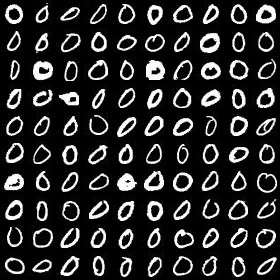

Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10


41791

In [44]:
size_dataset = size(X, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
img_grid_X=display_image_grid(X, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))
display(img_grid_X)
save("Matrix_of_"*string(number)*"s.jpeg", img_grid_X)

In [14]:
number2 = 7
folder2 = raw"MNIST\trainingSet\\"*string(number2)
Y, h, w = load_images_as_dataset(folder2)
size(Y) 

Dimensões da imagem: 28 x 28


(100, 784)

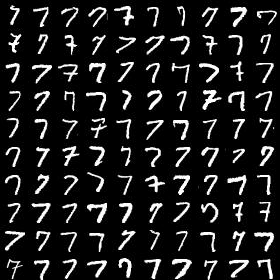

Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10


35379

In [45]:

size_dataset = size(Y, 1)
grid_rows, grid_cols = best_grid_shape(size_dataset)
println("Número de imagens no dataset: ", size_dataset)
println("Número de linhas do grid: ", grid_rows)
println("Número de colunas do grid: ", grid_cols)
img_grid_Y=display_image_grid(Y, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))
display(img_grid_Y)
save("Matrix_of_"*string(number2)*"s.jpeg", img_grid_Y)

In [16]:
println("Tamanho do dataset X: ", size(X))
println("Tamanho do dataset Y: ", size(Y))
println("tamanho da imagem: ", h, " x ", w)


Tamanho do dataset X: (100, 784)
Tamanho do dataset Y: (100, 784)
tamanho da imagem: 28 x 28


In [17]:
# Exemplo de uso da função build_csd_input_matrix
Q, r1, c1, E, E1, F1, R1, R2 = build_csd_input_matrix(X, Y)

Q1: (784, 100)
R1: (100, 100)
Q2: (784, 100)
R2: (100, 100)


([0.35610317474137787 0.2739093827798639 … 0.009646027008094932 7.651977915217913e-5; 0.18507543774929655 0.2619191816465788 … -0.021519965898868492 0.003742111006965263; … ; 0.003594875154776649 0.025906934977326806 … 0.002975775164855945 0.03431025671685306; -0.0024460619998165466 -0.0033660570423307504 … 0.01626521003895587 -0.0006615544402227896], 100, 100, [-0.0009449456342940366 0.000527977175154637 … 0.005707275604515305 -0.02341711155644512; 0.0 0.0 … -0.04762126333335396 -0.012698608984082548; … ; 0.0 0.0 … -0.009804807789151678 0.01129421781796674; 0.0 0.0 … 0.030648732358974456 -0.0023831676701779117], [-0.0009449456342940366 0.000527977175154637 … 0.00019450418572064686 0.0007940293595595696; 0.0 0.0 … -0.0011775876994296133 -0.001583189425252094; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 1.0408340855860843e-16 … -0.004246854466660319 -0.004306760033274941; 0.0 0.0 … 0.00037553688678467015 -0.0016626654569694415; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-12.4501404

In [18]:
println(size(Q))  # Verifica o tamanho da matriz Q
println("Posto de D1: ", r1)
println("Posto de D2: ", c1)
println("Tamanho de E1: ", size(E1))  # Verifica o tamanho de E1
println("Tamanho de F1: ", size(F1))  # Verifica o tamanho de E2
println("Tamanho de R1: ", size(R1))  # Verifica o tamanho de R1
println("Tamanho de R2: ", size(R2))  # Verifica o tamanho de R2

(784, 784)
Posto de D1: 100
Posto de D2: 100
Tamanho de E1: (784, 100)
Tamanho de F1: (784, 100)
Tamanho de R1: (100, 100)
Tamanho de R2: (100, 100)


In [19]:
# Exibir e verificar a corretude da matriz A
verify_Q(Q)
X_reconstructed = rebuild_datasets_matrices(E1, R1)
Y_reconstructed = rebuild_datasets_matrices(F1, R2)

if X_reconstructed ≈ X && Y_reconstructed ≈ Y
    println("As matrizes reconstruídas são equivalentes às originais!")
else
    println("As matrizes reconstruídas NÃO são equivalentes às originais.")
        
end

A matriz Q é ortonormal
As matrizes reconstruídas são equivalentes às originais!


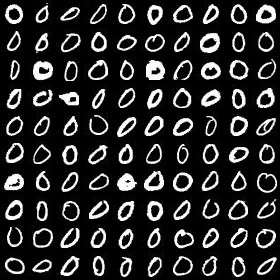

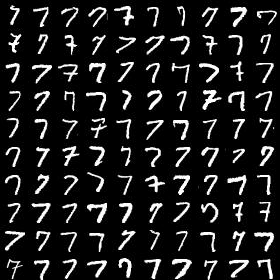

In [20]:
display(display_image_grid(X_reconstructed, (h, w), collect(1:size(X_reconstructed, 1)); grid_shape=(grid_rows, grid_cols)))
display(display_image_grid(Y_reconstructed, (h, w), collect(1:size(Y_reconstructed, 1)); grid_shape=(grid_rows, grid_cols)))

In [21]:
function csd(Q, c1, r1, E)
    d= size(Q, 1)  # Dimensão do espaço
    # separar Q em blocos
    Q11 = Q[1:r1, 1:c1]  # r1 x c1
    Q12 = Q[1:r1, c1+1:end]  # r1 x (d - c1)
    Q21 = Q[r1+1:end, 1:c1]  # ( d - r1) x c1
    Q22 = Q[r1+1:end, c1+1:end]  # (d - r1) x (d - c1)

    # SVD dos blocos de Q = EᵀF
    U1, S11, V1 = svd(Q11; full=true)     
    U2, S22, V2  = svd(Q22; full=true)

    D11 = U1' * Q11 * V1
    D12 = U1' * Q12 * V2 
    D21 = U2' * Q21 * V1
    D22 = U2' * Q22 * V2
    
    # Monta matriz diagonalizada D via blocos projetados
    D_top = hcat(D11, D12)  # r1 x d
    D_bot = hcat(D21, D22)  # (d - r1) x (d - c1)
    D = vcat(D_top, D_bot)  # d × d

    # Constrói matriz U unificada
    U = Matrix{Float64}(I, d, d)
    U[1:r1, 1:r1] = U1
    U[r1+1:end, r1+1:end] = U2
    
    # Constrói matriz V unificada
    V= Matrix{Float64}(I, d, d)
    V[1:c1, 1:c1] = V1
    V[c1+1:end, c1+1:end] = V2
    
    # Calcula os ângulos θ entre os subespaços
    θ = acos.(clamp.(S11, -1.0, 1.0))

    # Reconstrói a rotação W que leva E1 → F1
    W = E * U * D * U' * E'


    return U, U1, U2, V, V1, V2, D, θ, W  
end

csd (generic function with 1 method)

In [22]:
U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)

([-0.5350644030301964 -0.4416362788988202 … 0.0 0.0; -0.5242149402863954 0.38957759720205787 … 0.0 0.0; … ; 0.0 0.0 … -0.04234567279627266 -0.051554448633678876; 0.0 0.0 … -0.06684254854186777 -0.028835448191584193], [-0.5350644030301964 -0.4416362788988202 … -0.05340879859534432 0.05382403929066203; -0.5242149402863954 0.38957759720205787 … 0.01836738474345103 0.043280409518673055; … ; -0.017959242063778604 0.005832038286931738 … -0.019870645412875823 -0.21664821096123482; 0.03839206082940285 0.004903589066192202 … -0.02518756409601565 0.08362183202029097], [0.034626991119841605 -0.014099046755839558 … 0.04545539726509673 -0.04350632051432697; -0.024963878649510073 0.015596803018332436 … 0.022441300046231537 0.035462314685807524; … ; -0.017395632761972087 -0.03731995166877132 … -0.04234567279627266 -0.051554448633678876; 0.025695853600373606 -0.013802438270159242 … -0.06684254854186777 -0.028835448191584193], [-0.5682385735360769 0.01040942911138534 … 0.0 0.0; -0.48745979979391774 -0.

In [23]:
display(θ)                 # Ângulos principais entre subespaços (em radianos)
@show(U*D*V' ≈ Q) 
display(norm(W-I) ≈ norm(D-I))  # Deve ser próximo de 0 (rotação direta correta)
@show W*E1*U1*V1' ≈ F1 

100-element Vector{Float64}:
 0.17772594990677731
 0.23581456390967295
 0.2608977503119041
 0.2648104030128924
 0.30304654046825263
 0.3243882723133219
 0.35009215463008725
 0.37366380585091935
 0.4073315751670618
 0.423099635391673
 ⋮
 1.5031688722899046
 1.5113519822864636
 1.518035766187841
 1.524855204002785
 1.5467066175178747
 1.5497936556938385
 1.5501828360785737
 1.5590100455692184
 1.5674600784935284

true

U * D * V' ≈ Q = true
W * E1 * U1 * V1' ≈ F1 = true


true

In [24]:
function verify_nonzero_values_D(l)
    vals = Float64[]  # vetor vazio para armazenar os valores significativos

    println("Entradas significativas da linha $l de D:")

    for i in 1:size(D, 2)
        val = D[l, i]
        if abs(val) > 1e-10  
            println("D[$l, $i] = $val")
            push!(vals, val)
        end
    end

    println("Valores coletados: ", vals)

    if size(vals,1)>1
        println("Soma dos quadrados: ",vals[1]^2+vals[2]^2)
        println("Ângulo do cosseno: ",acos(vals[1]).* (180 / π))
        println("Ângulo do seno: ",asin(vals[2]).* (180 / π))
    end
end


verify_nonzero_values_D (generic function with 1 method)

In [41]:
verify_nonzero_values_D(14) 

Entradas significativas da linha 14 de D:
D[14, 14] = 0.8824110493608825
D[14, 698] = -0.47047926624435515
Valores coletados: [0.8824110493608825, -0.47047926624435515]
Soma dos quadrados: 1.0000000000000007
Ângulo do cosseno: 28.065411239981408
Ângulo do seno: -28.06541123998146


In [26]:
Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*U1*V1', R2)

if  Y_reconstructed_from_rotation ≈ Y
    println("A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D")
else
    println("A matriz Y reconstruída a partir da rotação de X NÃO é equivalente à original. T-T")
end

A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D


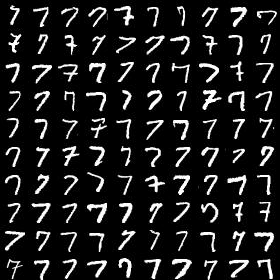

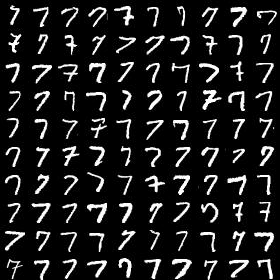

In [27]:
display(display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols)))
display(display_image_grid(Y, (h, w), collect(1:size(Y, 1)); grid_shape=(grid_rows, grid_cols)))

In [28]:
function smooth_transition(Q, c1, r1, h, w, E, E1, R2, n_frames, num_X, num_Y)
    U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)
    frames = []
    max_angle= Diagonal(θ)
    d=size(D, 1)  # Dimensão do espaço
    I_d = Matrix{Float64}(I, d, d)
    I_u = Matrix{Float64}(I, r1, r1)
    I_v = Matrix{Float64}(I, c1, c1)

    for mask in range(0, 1, length=n_frames)       
        Dm = mask * D + (1- mask )*I_d  # Aplicando máscara de ângulos
        Um = mask * U1 + (1- mask )*I_u  # Aplicando máscara de U
        Vm = mask * V1 + (1- mask )*I_v  # Aplicando máscara de V
        W = E * U * Dm * U' * E'
        Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*Um*Vm', R2)
        img = display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols))
        frame = clamp.(img,0,1)
        push!(frames, frame)
    end
    save("CSD_rotation_"*string(num_X)*"-"*string(num_Y)*".gif", cat(frames..., dims=3))
    empty!(frames)

end

smooth_transition (generic function with 1 method)

In [29]:
smooth_transition(Q, c1, r1, h, w, E, E1, R2, 30, number, number2)

Any[]

In [30]:
function rotation_of_subspaces(n1,n2,m= 100)
    folderx = raw"MNIST\trainingSet\\"*string(n1)
    X, h, w = load_images_as_dataset(folderx, m)
    size(X) 
    
    foldery = raw"MNIST\trainingSet\\"*string(n2)
    Y, h, w = load_images_as_dataset(foldery , m)
    size(Y) 

    size_dataset = size(X, 1)
    grid_rows, grid_cols = best_grid_shape(size_dataset)
    println("Número de imagens no dataset: ", size_dataset)
    println("Número de linhas do grid: ", grid_rows)
    println("Número de colunas do grid: ", grid_cols)
    display_image_grid(X, (h, w), collect(1:size_dataset); grid_shape=(grid_rows, grid_cols))
    
    Q, r1, c1, E, E1, F1, R1, R2 = build_csd_input_matrix(X, Y)

    # Exibir e verificar a corretude da matriz A
    verify_Q(Q)
    X_reconstructed = rebuild_datasets_matrices(E1, R1)
    Y_reconstructed = rebuild_datasets_matrices(F1, R2)

    if X_reconstructed ≈ X && Y_reconstructed ≈ Y
        println("As matrizes reconstruídas são equivalentes às originais!")
    else
        println("As matrizes reconstruídas NÃO são equivalentes às originais.")
            
    end

    display(display_image_grid(X_reconstructed, (h, w), collect(1:size(X_reconstructed, 1)); grid_shape=(grid_rows, grid_cols)))
    display(display_image_grid(Y_reconstructed, (h, w), collect(1:size(Y_reconstructed, 1)); grid_shape=(grid_rows, grid_cols)))


    U, U1, U2, V, V1, V2, D, θ, W =csd(Q, c1, r1, E)

    display("angulos entre os subespaços:")
    display(θ.* (180 / π))    # Ângulos principais entre subespaços (em graus)
    @show(U*D*V' ≈ Q)
    Y_reconstructed_from_rotation = rebuild_datasets_matrices(W*E1*U1*V1', R2)

    if  Y_reconstructed_from_rotation ≈ Y
        println("A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D")
    else
        println("A matriz Y reconstruída a partir da rotação de X NÃO é equivalente à original. T-T")
    end
    
    display(display_image_grid(Y_reconstructed_from_rotation, (h, w), collect(1:size(Y_reconstructed_from_rotation, 1)); grid_shape=(grid_rows, grid_cols)))
    display(display_image_grid(Y, (h, w), collect(1:size(Y, 1)); grid_shape=(grid_rows, grid_cols)))

    smooth_transition(Q, c1, r1, h, w, E, E1, R2, 30, n1, n2)
    println("GIF de rotação salvo como CSD_rotation_"*string(n1)*"-"*string(n2)*".gif")
    
    return nothing

end
    

rotation_of_subspaces (generic function with 2 methods)

Dimensões da imagem: 28 x 28
Dimensões da imagem: 28 x 28
Número de imagens no dataset: 100
Número de linhas do grid: 10
Número de colunas do grid: 10
Q1: (784, 100)
R1: (100, 100)
Q2: (784, 100)
R2: (100, 100)
A matriz Q é ortonormal
As matrizes reconstruídas são equivalentes às originais!
U * D * V' ≈ Q = true
A matriz Y reconstruída a partir da rotação de X é equivalente à original! :D
GIF de rotação salvo como CSD_rotation_2-6.gif


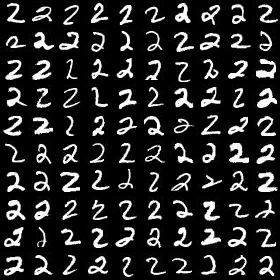

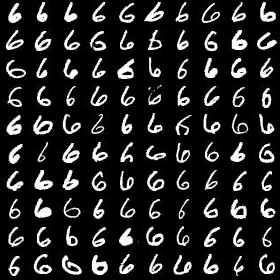

"angulos entre os subespaços:"

100-element Vector{Float64}:
  7.322803523481787
 11.069411940988651
 14.163971687945729
 14.587536611827636
 16.796409595229512
 17.48040002365549
 18.087071462857995
 19.304613089693394
 20.079170744054323
 21.304581801463787
  ⋮
 84.5616445692373
 85.39468887234604
 86.08925327883479
 86.68803484420928
 87.56844047673232
 87.96791553046761
 88.02744667870853
 89.06132262639179
 89.46987445359234

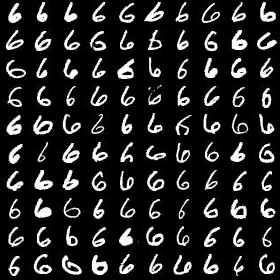

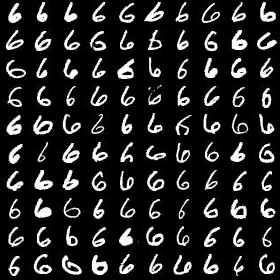

In [50]:
rotation_of_subspaces(2, 6, 100)